In [115]:
!pip install pandahouse

In [116]:
import pandas as pd
import scipy.stats as ss

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Задача
Мы наблюдаем внезапное падение активной аудитории! Нужно разобраться, какие пользователи не смогли воспользоваться лентой новостей, что их объединяет?

# Решение

In [117]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}
db='simulator_20240320'

In [118]:
q = f"""
SELECT
  DATE(time) AS date,
  COUNT(DISTINCT user_id) DAU
FROM {db}.feed_actions
GROUP BY date
ORDER BY date
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,DAU
0,2024-02-03,878
1,2024-02-04,2238
2,2024-02-05,3105
3,2024-02-06,3721
4,2024-02-07,4617


In [119]:
px.line(df, x='date', y='DAU')

In [120]:
q = f"""
SELECT
  DATE(time) AS date,
  COUNT(DISTINCT user_id) DAU
FROM {db}.feed_actions
WHERE date = toDate('2024-03-23')
GROUP BY date
"""

pandahouse.read_clickhouse(q, connection=connection)

,date,DAU
0,2024-03-23,14073


Провал пользователей произошёл 23.03.2024

In [121]:
target_date = "toDate('2024-03-23')"

## Возможные причины

Посчитаем retention

In [122]:
# retention для всех когорт (с фильтрацией в диапазоне 2024-03-23)
q = f"""
WITH t_users_actions AS (
  -- Действия пользователям по дням
  SELECT DISTINCT
    user_id,
    DATE(time) AS date
  FROM {db}.feed_actions
  WHERE date BETWEEN {target_date}-8 AND {target_date}+3
),
t_cohorts AS (
  -- Когорты пользователей
  SELECT
    user_id,
    date,
    MIN(date) OVER (
      PARTITION BY user_id
    ) AS cohort
  FROM t_users_actions
),
t_retention_1 AS (
  -- Количество когортных пользователей по периодам
  SELECT
    COUNT(DISTINCT user_id) AS uniqs,
    cohort,
    date
  FROM t_cohorts
  GROUP BY cohort, date
),
t_retention_2 AS (
  -- Количество пользователей в day_0 для когорт
  SELECT
    uniqs,
    cohort,
    date,
    MAX(uniqs) OVER (
      PARTITION BY cohort
    ) AS uniqs_day_0,
    date - cohort as dt
  FROM t_retention_1
),
t_retention AS (
  SELECT
    ROUND(uniqs / uniqs_day_0 * 100) AS metric,
    cohort,
    dt,
    date
  FROM t_retention_2
)


SELECT *
FROM t_retention
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.metric = df.metric.apply(lambda x: int(x))
df.cohort = df.cohort.apply(lambda x: str(x)[6:11])
df.date = df.date.apply(lambda x: str(x)[6:11])

max_el = max(el for el in df.metric if el != 100)

df = df.pivot(index='cohort', columns='date', values='metric')
 # heatmap
cm = sns.color_palette("magma", as_cmap=True)
df = (
    df
    .style
    .background_gradient(
        cmap=cm,
        axis=None,
        vmax=max_el
    )
    .format('{:.0f}')
    .applymap(lambda x: 'color: transparent' if pd.isnull(x) else '')
    .highlight_null('white')
)
df

date,3-15,3-16,3-17,3-18,3-19,3-20,3-21,3-22,3-23,3-24,3-25,3-26
cohort,,,,,,,,,,,,
3-15,100,24,23,22,21,19,19,18,13,17,16,15
3-16,nan,100,24,23,22,20,19,19,13,17,17,15
3-17,nan,nan,100,23,22,21,21,19,13,18,16,16
3-18,nan,nan,nan,100,25,23,23,21,14,21,19,18
3-19,nan,nan,nan,nan,100,23,22,20,15,18,18,18
3-20,nan,nan,nan,nan,nan,100,25,23,18,22,20,21
3-21,nan,nan,nan,nan,nan,nan,100,19,16,16,16,16
3-22,nan,nan,nan,nan,nan,nan,nan,100,15,16,16,15
3-23,nan,nan,nan,nan,nan,nan,nan,nan,100,25,27,23


Как можно заметить:
- для всех когорт 23.03.2024 наблюдается сниженный retention

Возможно, определённая категория пользователей в этот день не смогла зайти

### 1) ОС

In [123]:
q = f"""
SELECT
  os,
  COUNT(DISTINCT user_id)
FROM {db}.feed_actions
GROUP BY os
"""

pandahouse.read_clickhouse(q, connection=connection)

,os,uniqExact(user_id)
0,Android,74008
1,iOS,40015


In [124]:
# В целевой день
q = f"""
SELECT
  ROUND(countIf(user_id, os='Android') / COUNT(user_id) * 100, 1) AS andro_percent
FROM (
    SELECT DISTINCT
      user_id,
      os
    FROM {db}.feed_actions
    WHERE DATE(time) = {target_date}
  )
"""

pandahouse.read_clickhouse(q, connection=connection)

,andro_percent
0,65.6


In [125]:
# За день до целевого дня
q = f"""
SELECT
  ROUND(countIf(user_id, os='Android') / COUNT(user_id) * 100, 1) AS andro_percent
FROM (
    SELECT DISTINCT
      user_id,
      os
    FROM {db}.feed_actions
    WHERE DATE(time) = {target_date}-1
  )
"""

pandahouse.read_clickhouse(q, connection=connection)

,andro_percent
0,64.9


In [126]:
# За неделю до целевого дня
q = f"""
SELECT
  ROUND(countIf(user_id, os='Android') / COUNT(user_id) * 100, 1) AS andro_percent
FROM (
    SELECT DISTINCT
      user_id,
      os
    FROM {db}.feed_actions
    WHERE DATE(time) = {target_date}-7
  )
"""

pandahouse.read_clickhouse(q, connection=connection)

,andro_percent
0,64.9


In [127]:
# За всё время
q = f"""
SELECT
  ROUND(countIf(user_id, os='Android') / COUNT(user_id) * 100, 1) AS andro_percent
FROM (
    SELECT DISTINCT
      user_id,
      os
    FROM {db}.feed_actions
    -- WHERE DATE(time) = {target_date}-1
  )
"""

pandahouse.read_clickhouse(q, connection=connection)

,andro_percent
0,64.9


=> возможно, в целевой день зашло меньшее количество iOS пользователей, чем обычно

Сравнивать будем с предыдущим днём

In [128]:
feature = 'os'

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}
GROUP BY group
"""

contingency_table = pandahouse.read_clickhouse(q, connection=connection)

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users_prev
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}-1
GROUP BY group
"""

contingency_table['users_prev'] = pandahouse.read_clickhouse(q, connection=connection).users_prev
contingency_table.set_index('group', inplace=True)
contingency_table

,users,users_prev
group,,
Android,9235,10517
iOS,4838,5678


In [129]:
pval = ss.chi2_contingency(contingency_table.values)[1]
print(f'p-value: {round(pval, 3)}')

p-value: 0.218


=> статистически значимой разницы нет

### 2) source


In [130]:
feature = 'source'

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}
GROUP BY group
"""

contingency_table = pandahouse.read_clickhouse(q, connection=connection)

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users_prev
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}-1
GROUP BY group
"""

contingency_table['users_prev'] = pandahouse.read_clickhouse(q, connection=connection).users_prev
contingency_table.set_index('group', inplace=True)
contingency_table

,users,users_prev
group,,
ads,5677,6482
organic,8396,9713


In [131]:
pval = ss.chi2_contingency(contingency_table.values)[1]
print(f'p-value: {round(pval, 3)}')

p-value: 0.585


=> статистически значимой разницы нет

### 3) exp_group

In [132]:
feature = 'exp_group'

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}
GROUP BY group
"""

contingency_table = pandahouse.read_clickhouse(q, connection=connection)

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users_prev
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}-1
GROUP BY group
"""

contingency_table['users_prev'] = pandahouse.read_clickhouse(q, connection=connection).users_prev
contingency_table.set_index('group', inplace=True)
contingency_table

,users,users_prev
group,,
0,2860,3237
1,2850,3182
2,2783,3287
3,2816,3259
4,2764,3230


In [133]:
pval = ss.chi2_contingency(contingency_table.values)[1]
print(f'p-value: {round(pval, 3)}')

p-value: 0.523


=> статистически значимой разницы нет

### 4) country

In [134]:
feature = 'country'

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}
GROUP BY group
"""

contingency_table = pandahouse.read_clickhouse(q, connection=connection)

q = f"""
SELECT
  {feature} AS group,
  COUNT(DISTINCT user_id) AS users_prev
FROM {db}.feed_actions
WHERE DATE(time) = {target_date}-1
GROUP BY group
"""

contingency_table['users_prev'] = pandahouse.read_clickhouse(q, connection=connection).users_prev
contingency_table.set_index('group', inplace=True)
contingency_table

,users,users_prev
group,,
Russia,11908,14216
Turkey,180,149
Ukraine,906,776
Finland,155,163
Belarus,326,368
Latvia,19,18
Estonia,14,19
Cyprus,20,18
Switzerland,16,16


In [135]:
pval = ss.chi2_contingency(contingency_table.values)[1]
print(f'p-value: {round(pval, 3)}')

p-value: 0.0


=> имеется статзначимя разница

Похоже, что дела в пользователях из России



In [136]:
contingency_table['rus'] = contingency_table.index == 'Russia'
contingency_table.groupby('rus')[['users',	'users_prev']].sum()

,users,users_prev
rus,,
False,2165,1979
True,11908,14216


In [137]:
pval = ss.chi2_contingency(contingency_table.values)[1]
print(f'p-value: {round(pval, 3)}')

p-value: 0.0


Действительно, по некоторой причине отвалилась ощутимая часть пользователей из России

### Почему отвалилась часть пользователей из России?

In [138]:
target_date

"toDate('2024-03-23')"

In [139]:
target_date = pd.to_datetime('2024-03-23')
target_date

Timestamp('2024-03-23 00:00:00')

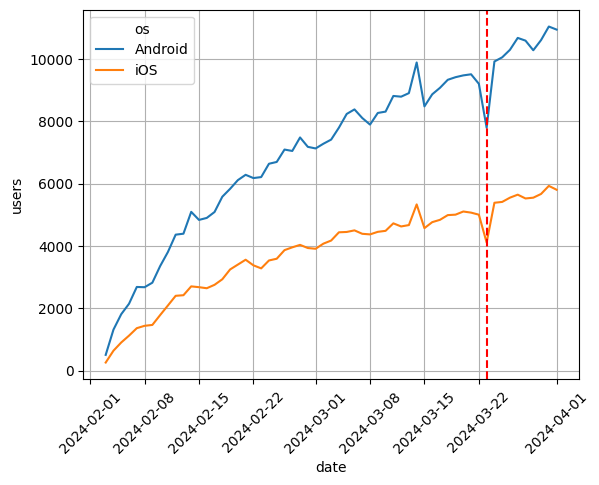

In [140]:
feature = 'os'

q = f"""
SELECT
  {feature},
  DATE(time) AS date,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE country='Russia'
GROUP BY {feature}, date
"""

df = pandahouse.read_clickhouse(q, connection=connection)

plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x='date', y='users', hue=feature)
plt.axvline(x=target_date, color='r', linestyle='--')
plt.show()

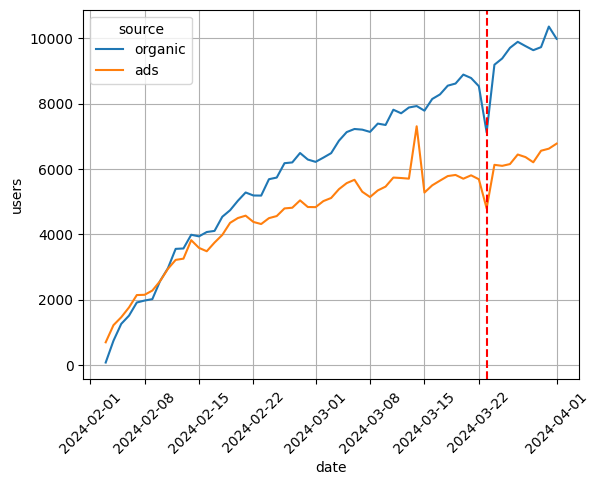

In [141]:
feature = 'source'

q = f"""
SELECT
  {feature},
  DATE(time) AS date,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE country='Russia'
GROUP BY {feature}, date
"""

df = pandahouse.read_clickhouse(q, connection=connection)

plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x='date', y='users', hue=feature)
plt.axvline(x=target_date, color='r', linestyle='--')
plt.show()

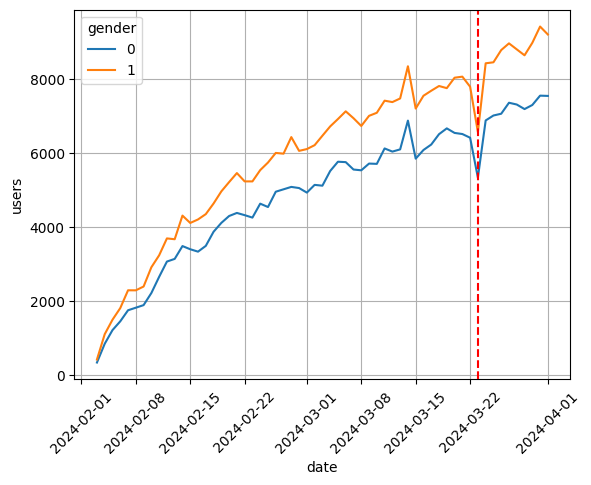

In [142]:
feature = 'gender'

q = f"""
SELECT
  {feature},
  DATE(time) AS date,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE country='Russia'
GROUP BY {feature}, date
"""

df = pandahouse.read_clickhouse(q, connection=connection)

plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x='date', y='users', hue=feature)
plt.axvline(x=target_date, color='r', linestyle='--')
plt.show()

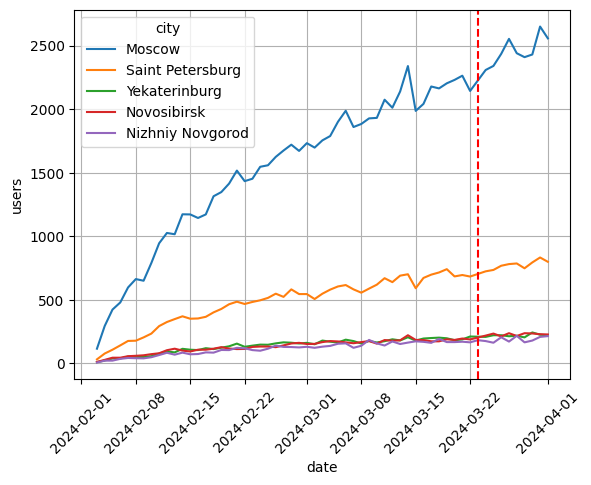

In [143]:
feature = 'city'

q = f"""
WITH main_groups AS (
  SELECT
    {feature},
    COUNT(DISTINCT user_id) AS users
  FROM {db}.feed_actions
  WHERE country='Russia'
  GROUP BY {feature}
  ORDER BY users DESC
  LIMIT 5
)

SELECT
  {feature},
  DATE(time) AS date,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE
  country='Russia'
  AND {feature} IN (SELECT {feature} FROM main_groups)
GROUP BY {feature}, date
ORDER BY users DESC
"""

df = pandahouse.read_clickhouse(q, connection=connection)

plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x='date', y='users', hue=feature)
plt.axvline(x=target_date, color='r', linestyle='--')
plt.show()

График с городами выглядит довольно странно. Спад активности за счёт кумулятивного эффекта?

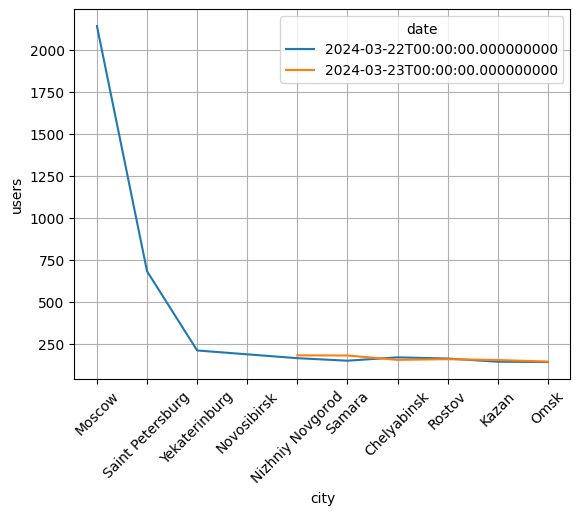

In [144]:
feature = 'city'
filter_date = "toDate('2024-3-23')"

q = f"""
WITH main_groups AS (
  SELECT
    {feature},
    COUNT(DISTINCT user_id) AS users
  FROM {db}.feed_actions
  WHERE country='Russia'
  GROUP BY {feature}
  ORDER BY users DESC
  LIMIT 10
)

SELECT
  {feature},
  DATE(time) AS date,
  COUNT(DISTINCT user_id) AS users
FROM {db}.feed_actions
WHERE
  country='Russia'
  AND {feature} IN (SELECT {feature} FROM main_groups)
  AND date>={filter_date}-1 AND date<={filter_date}
GROUP BY {feature}, date
ORDER BY users DESC
"""

df = pandahouse.read_clickhouse(q, connection=connection)

plt.grid()
plt.xticks(rotation=45)
sns.lineplot(df, x=feature, y='users', hue='date')
plt.show()

Как видно по графику выше - в Российских городах с наибольшей активностью в этот день не собиралась статистика

**Выводы:**
- спад активности связан с пользователями из России
- в Российских городах с наибольшей активностью в этот день не собиралась статистика